# Step 1. 모델 설계

## 1,1 라이브러리 불러오기

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

## 1.2 GPU 설정하기

In [3]:
# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


## 1.3 파일 시스템

In [4]:
# 자신의 폴더 경로에 맞게 재지정해주세요.
root_path = '/content/drive/MyDrive/동아리_스터디_대외활동/GDSC/week8/archive (1)/cityscapes_data/cityscapes_data'

data_dir = root_path

# data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
train_dir = os.path.join(data_dir, "train")

# data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
val_dir = os.path.join(data_dir, "val")

# train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
train_fns = os.listdir(train_dir)

# val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


## 1.4 샘플 이미지 검색

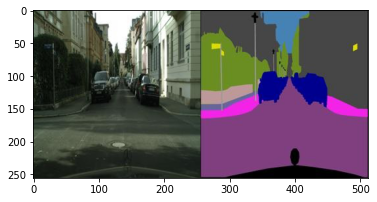

In [5]:
# train_dir(문자열)와 train_fns[0](문자열)의 경로를 결합하여 sample_image_fp(샘플 이미지의 경로)에 저장합니다.
sample_image_fp = os.path.join(train_dir, train_fns[0])

# PIL 라이브러리의 Image 모듈을 사용하여, sample_image_fp를 불러옵니다.
# RGB 형태로 변환하여 sample_image에 저장하는 것으로 이해했는데, ".convert("RGB")" 코드는 없어도 될 것 같습니다.
# Image.open() 함수 자체가 RGB의 형태로 불러오는 것으로 이해했습니다. 확실하지 않습니다...
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

## 1.5 Output Label 정의하기

In [6]:
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [7]:
num_classes = 10

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [8]:
# 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
def split_image(image) :
   image = np.array(image)
   
   # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
   # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

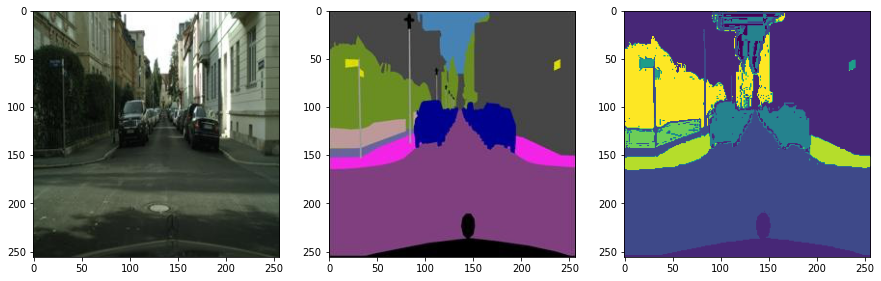

In [9]:
# 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

## 1.6 데이터셋 정의하기

In [10]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.image_fns)
    
  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class
    
  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label
    
  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)      

In [11]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


## 1.7 U-Net 모델 정의하기

In [12]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [13]:
model = UNet(num_classes=num_classes)

In [14]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [15]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 1.7.1 U-Net 모델 코드 수정

In [16]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
	# 1x1 convolution layer 추가
        self.output1 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out1 = self.output(output_out) # [-1, num_classes, 256, 256]
        
        return output_out1

# Step 2. 모델 학습

In [17]:
batch_size = 4

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0
  
  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

In [18]:
# 학습을 통해 얻은 손실함수 확인
print(len(epoch_losses))
print(epoch_losses)

10
[1.2444697366126123, 0.9089996799506167, 0.8439605909409702, 0.8049068748950958, 0.8994546159300753, 0.8067851494797456, 0.7628274850787655, 0.7317340422061182, 0.6981263789999229, 0.6784607103515056]


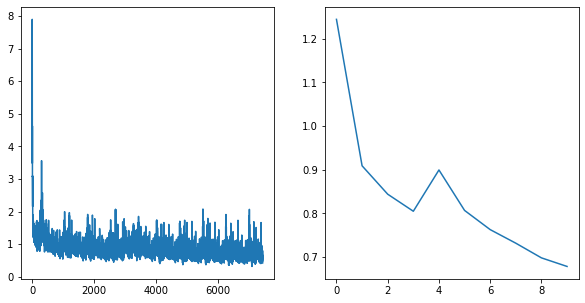

In [19]:
# 학습의 결과 그래프 확인
# 왼쪽이 step_losses, 오른쪽이 epoch_losses의 결과 그래프입니다.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

plt.show()

In [20]:
# 모델 저장
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# Step 3. 모델 평가하기

In [21]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 64, 256, 256])
torch.Size([8, 256, 256])


In [23]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

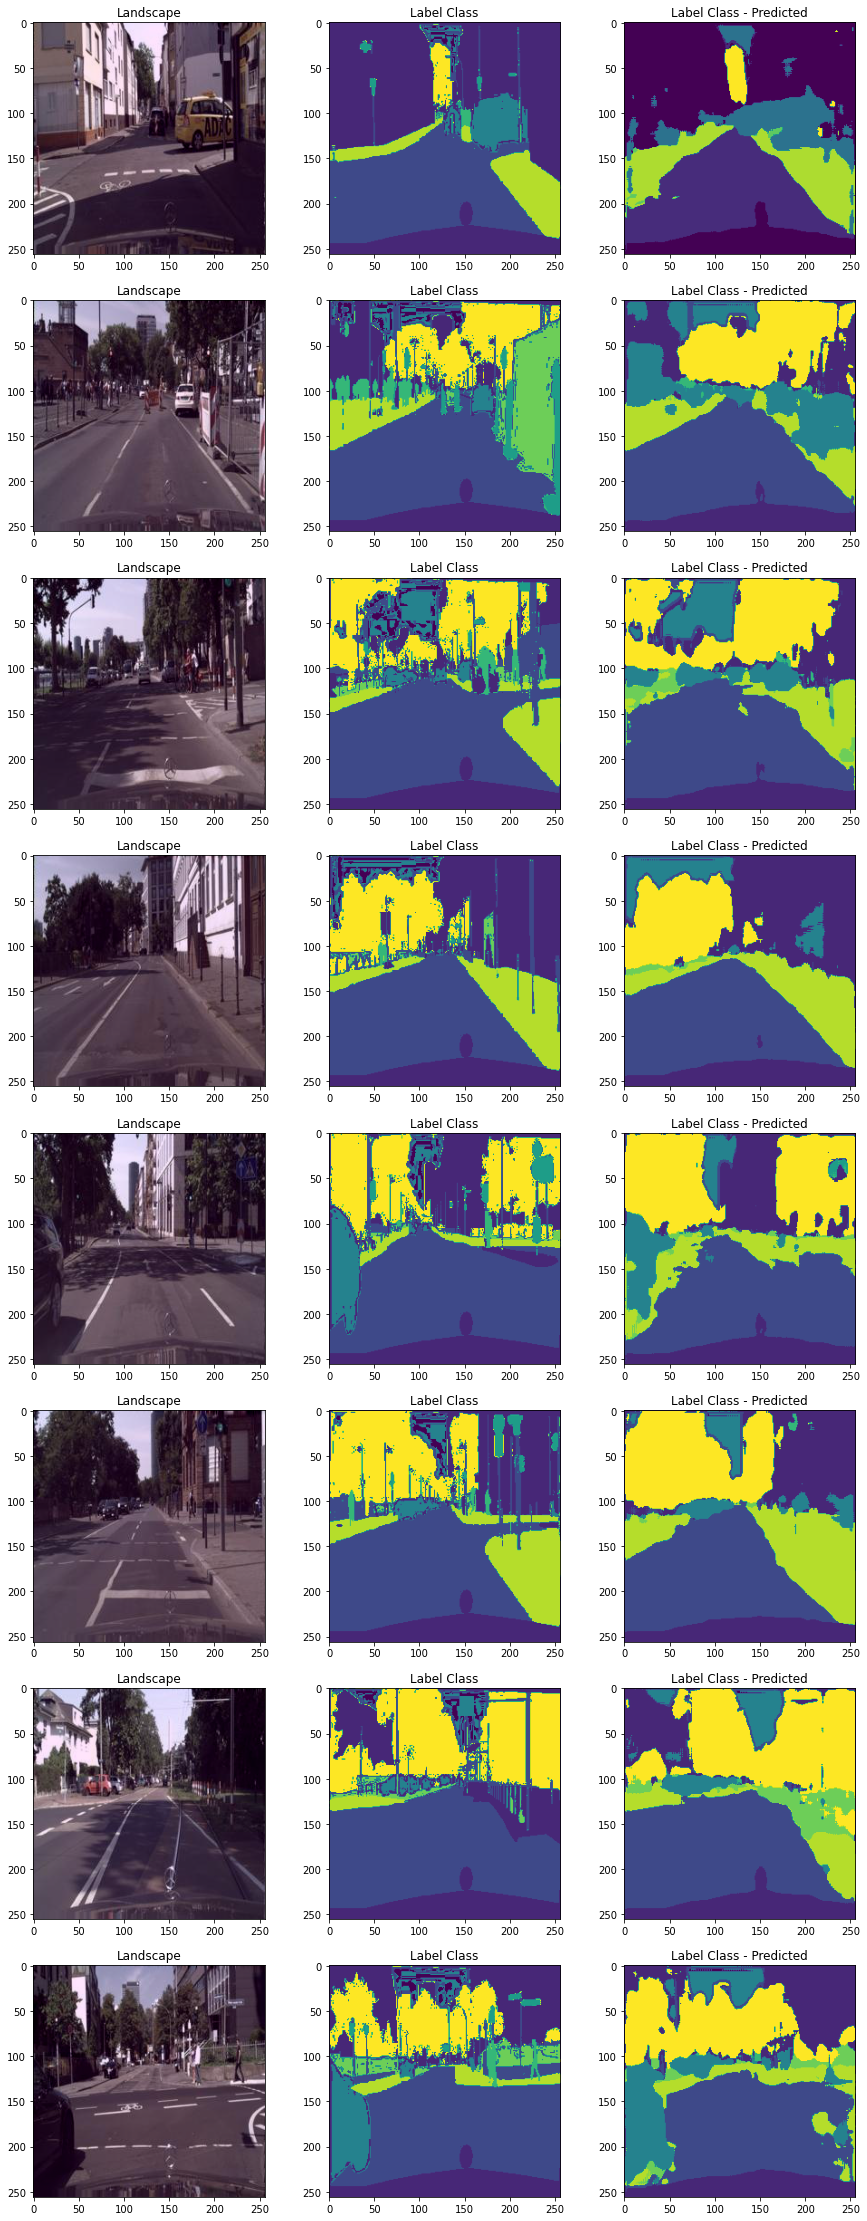

In [24]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# Step 4. IOU Score


In [25]:
print(sum(iou_scores) / len(iou_scores))

0.9875688506718803
